# Intro<br>
Use Agglomerative to cluster. Then points that are too far away to cluster / clusters that are very small are marked as anomalies.

# Import data and libraries

In [1]:
%reload_ext autoreload
%autoreload 2

import sys
from importlib import reload
import pandas as pd

# sys.path.append(r"E:\enyutan\Document\2025 MJE Advanced Analytics\Ishi")
import _00_util_sql
reload(_00_util_sql)
from _00_util_sql import Conn_ODBC

In [5]:
# Import packages
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
import gower
from gower import gower_matrix
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt

import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [6]:
sql_db=Conn_ODBC(database="JE_ML_2025")
##### Import data 
conn=sql_db.odbc_conn_db_pyodbc()
sql_query=f"SELECT * FROM data_p_ishi_GL_JE_cleaned_2019 WHERE AccDocNo LIKE '99%'"
sales_df=sql_db.odbc_run_sql(conn, sql_query, return_result=True)
conn.close()

sales_df.head(5)
# 1-2 mins

,FiscalYear,AccDocNo,Dr_Cr,DateOfAccDocEntry,DateOfAccDocEntry_and_TimeOfEntry (MYT),NoOfLineItemInAccDoc,GL_DESCRIPTION,Amt_localCurrencyFormatted,Document Type Description,Quantity,...,Dr_Liability - G\L Account,Dr_Liability - Vendor,Dr_Other Costs - G\L Account,Dr_Other Revenue - G\L Account,Dr_Revenue - G\L Account,IS Rep,OS Rep,Carrier Key Desc,Customer PO Number,Sold-To Id
0,2019,9911456081,"[Dr, Cr, Cr, Dr]",2019-01-15,2019-01-16 12:32:37,"[001, 002, 003, 004]","[Accounts Receivable Control Account, Third Pa...","[905.0, -905.0, -802.87, 802.87]",Billing Doc.Transfer,"[0.0, 10.0, 0.0, 0.0]",...,0.0,0.0,0.0,0.0,0.0,None,None,None,None,None
1,2019,9911456082,"[Dr, Cr, Cr, Dr]",2019-01-15,2019-01-16 12:32:38,"[001, 002, 003, 004]","[Accounts Receivable Control Account, Third Pa...","[1860.0, -1860.0, -1736.22, 1736.22]",Billing Doc.Transfer,"[0.0, 40.0, 0.0, 0.0]",...,0.0,0.0,0.0,0.0,0.0,None,None,None,None,None
2,2019,9911456340,"[Dr, Cr, Cr, Cr, Cr]",2019-01-15,2019-01-16 12:47:22,"[001, 002, 003, 004, 005]","[Accounts Receivable Control Account, Third Pa...","[316.0, -79.0, -79.0, -79.0, -79.0]",Billing Doc.Transfer,"[0.0, 1.0, 1.0, 1.0, 1.0]",...,0.0,0.0,0.0,0.0,0.0,None,None,None,None,None
3,2019,9911456098,"[Dr, Cr, Cr, Dr]",2019-01-25,2019-01-25 20:00:33,"[001, 002, 003, 004]","[Accounts Receivable Control Account, Third Pa...","[1122.0, -1122.0, -1006.08, 1006.08]",Billing Doc.Transfer,"[0.0, 11.0, 0.0, 0.0]",...,0.0,0.0,0.0,0.0,0.0,None,None,None,None,None
4,2019,9911456169,"[Dr, Cr]",2019-01-17,2019-01-17 16:10:08,"[001, 002]","[Accounts Receivable Control Account, Third Pa...","[1325.0, -1325.0]",Billing Doc.Transfer,"[0.0, 5.0]",...,0.0,0.0,0.0,0.0,0.0,None,None,None,None,None


# Feature Engineering

In [7]:
amounts = [
'Cr_Asset - Asset',
'Cr_Asset - Customer', 
'Cr_Asset - G\\L Account', 
'Cr_Asset - Material',
'Cr_Cost of Goods Sold (COGS) - G\\L Account',
'Cr_Expense (6) - G\\L Account',
'Cr_Liability - G\\L Account', 
'Cr_Liability - Vendor',
'Cr_Other Costs - G\\L Account', 
'Cr_Other Revenue - G\\L Account', 
'Cr_Revenue - G\\L Account', 
'Dr_Asset - Asset', 
'Dr_Asset - Customer', 
'Dr_Asset - G\\L Account', 
'Dr_Asset - Material', 
'Dr_Cost of Goods Sold (COGS) - G\\L Account', 
'Dr_Expense (6) - G\\L Account', 
'Dr_Liability - G\\L Account', 
'Dr_Liability - Vendor', 
'Dr_Other Costs - G\\L Account', 
'Dr_Other Revenue - G\\L Account', 
'Dr_Revenue - G\\L Account'
]

In [5]:
features = [
'GL_DESCRIPTION',
'Amt_localCurrencyFormatted',
'Document Type Description',
'Quantity',
'Username',
'TransactionCode',
'DocHeaderText',
'IsDocReversalOrReversedDoc',
'IdOfLineItem',
'PostingKey',
'isLineItemAutomaticallyCreated',
'TermsOfPayment',
'CashDiscountAmountInLocalCurrency',
'PaymentMethod',
'Plant',
'hasSubsequentDrCrMemo',
'WBSElement',
'SpecialGLIndicator',

'GL_AccType_AccountTypeDesc',
'Username Type',
'Amt_DocCurrency_NoOfTrailingZeroes',
'CashDiscountPercentage',
'IND_MonthEnd',
'IND_QuarterEnd',
'IND_YearEnd',
'IND_Weekend',
'IND_PublicHol',
'IND_OutsideWorkHours',

# New features from ZOTC
# 'Carrier Key Desc'
]

In [ ]:
# Get revenue accounts and calculate the revenue earned by these accounts
# List to store matches
revenue_list = []

# String to search for
search_term = "revenue"

# Case-insensitive search and add matches to new list
for s in amounts:
    if search_term.lower() in s.lower():
        revenue_list.append(s)

print(revenue_list)

def calculate_revenue(row, revenue_list):
    total = 0
    for col in revenue_list:
        if col.startswith('Cr_'):
            total -= row[col]
        elif col.startswith('Dr_'):
            total -= row[col]
    return total

# Apply function row-wise
sales_df['Revenue'] = sales_df.apply(calculate_revenue, axis=1, revenue_list=revenue_list)

['Cr_Other Revenue - G\\L Account', 'Cr_Revenue - G\\L Account', 'Dr_Other Revenue - G\\L Account', 'Dr_Revenue - G\\L Account']


## Mark if any 1<br>
Change certain columns to indicators / Make other indicator columns into 1

In [ ]:
# Flag journal entries where there are trailing 0s in the amount transacted (Amt_DocCurrency)
df_result = sales_df.copy()
df_result['Amt_DocCurrency_NoOfTrailingZeroes_flag'] = df_result['Amt_DocCurrency_NoOfTrailingZeroes'].apply(lambda x: int(any(val > 0 for val in x)))

In [ ]:
# Make a new column which indicates whether any of the listed columns have 1 (present)

def mark_any_one(df, cols, new_col_name='has_one'):
    df[new_col_name] = df[cols].apply(lambda row: int(1 in row.values), axis=1)
    return df

# Checking if the journal document was made at the end of a period (Year or quarter or month)
merge_cols = ['IND_MonthEnd', 'IND_QuarterEnd', 'IND_YearEnd']
mark_any_one(df_result, merge_cols, new_col_name='EndCheck')    

# Checking if the journal document was made outside work hours
merge_cols = ['IND_Weekend', 'IND_PublicHol', 'IND_OutsideWorkHours']
mark_any_one(df_result, merge_cols, new_col_name='OtherCheck')

,FiscalYear,AccDocNo,Dr_Cr,DateOfAccDocEntry,DateOfAccDocEntry_and_TimeOfEntry (MYT),NoOfLineItemInAccDoc,GL_DESCRIPTION,Amt_localCurrencyFormatted,Document Type Description,Quantity,...,Dr_Revenue - G\L Account,IS Rep,OS Rep,Carrier Key Desc,Customer PO Number,Sold-To Id,Revenue,Amt_DocCurrency_NoOfTrailingZeroes_flag,EndCheck,OtherCheck
0,2019,9911456081,"[Dr, Cr, Cr, Dr]",2019-01-15,2019-01-16 12:32:37,"[001, 002, 003, 004]","[Accounts Receivable Control Account, Third Pa...","[905.0, -905.0, -802.87, 802.87]",Billing Doc.Transfer,"[0.0, 10.0, 0.0, 0.0]",...,0.00,None,None,None,None,None,905.00,0,0,0
1,2019,9911456082,"[Dr, Cr, Cr, Dr]",2019-01-15,2019-01-16 12:32:38,"[001, 002, 003, 004]","[Accounts Receivable Control Account, Third Pa...","[1860.0, -1860.0, -1736.22, 1736.22]",Billing Doc.Transfer,"[0.0, 40.0, 0.0, 0.0]",...,0.00,None,None,None,None,None,1860.00,1,0,0
2,2019,9911456340,"[Dr, Cr, Cr, Cr, Cr]",2019-01-15,2019-01-16 12:47:22,"[001, 002, 003, 004, 005]","[Accounts Receivable Control Account, Third Pa...","[316.0, -79.0, -79.0, -79.0, -79.0]",Billing Doc.Transfer,"[0.0, 1.0, 1.0, 1.0, 1.0]",...,0.00,None,None,None,None,None,316.00,0,0,0
3,2019,9911456098,"[Dr, Cr, Cr, Dr]",2019-01-25,2019-01-25 20:00:33,"[001, 002, 003, 004]","[Accounts Receivable Control Account, Third Pa...","[1122.0, -1122.0, -1006.08, 1006.08]",Billing Doc.Transfer,"[0.0, 11.0, 0.0, 0.0]",...,0.00,None,None,None,None,None,1122.00,0,1,1
4,2019,9911456169,"[Dr, Cr]",2019-01-17,2019-01-17 16:10:08,"[001, 002]","[Accounts Receivable Control Account, Third Pa...","[1325.0, -1325.0]",Billing Doc.Transfer,"[0.0, 5.0]",...,0.00,None,None,None,None,None,1325.00,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156735,2019,9950839152,"[Cr, Dr]",2019-10-01,2019-10-02 11:15:17,"[001, 002]","[Accounts Receivable Control Account, Sales Re...","[-614.4, 614.4]",Bill Doc.Tr - Cr Mem,"[0.0, 1.0]",...,614.40,[Soo Peng Lau],[CHANG BOON LOH],WILL CALL,[RMAC-85521-M9J7/RMA5877],SNS NETWORK (M) SDN BHD,-614.40,0,0,0
156736,2019,9950839153,"[Cr, Dr, Dr, Cr]",2019-10-01,2019-10-02 11:15:17,"[001, 002, 003, 004]","[Intercompany Receivables Non Trade, Intercomp...","[-348.06, 348.06, 348.06, -348.06]",Bill Doc.Tr - Cr Mem,"[0.0, 1.0, 0.0, 0.0]",...,348.06,[Dummy Sales Rep],[],WILL CALL,[RMAC-84452-B2Z8/RyanTiew],INGRAM MICRO (MALAYSIA) SDN BHD,-348.06,0,0,0
156737,2019,9950839180,"[Cr, Dr]",2019-10-01,2019-10-02 12:15:14,"[001, 002]","[Accounts Receivable Control Account, Sales Re...","[-703.5, 703.5]",Bill Doc.Tr - Cr Mem,"[0.0, 1.0]",...,703.50,[Pao Von Tan],[Pao Von Tan],WILL CALL,[RMAC-85578-Y3Z2/EU-TanLeanHeoh],ST CONNECTION SDN BHD (AIA FITBIT),-703.50,0,0,0
156738,2019,9950839181,"[Cr, Dr, Dr, Cr]",2019-10-01,2019-10-02 12:15:15,"[001, 002, 003, 004]","[Accounts Receivable Control Account, Sales Re...","[-576.68, 576.68, 64.07, -64.07]",Bill Doc.Tr - Cr Mem,"[0.0, 1.0, 0.0, 0.0]",...,576.68,[Pao Von Tan],[Pao Von Tan],WILL CALL,[RMACN-84453-Q3F7/PRNo-19/JUL-001612],ST CONNECTION SDN BHD (CITY CHAIN),-576.68,0,0,0


In [11]:
cols = ['IND_Weekend', 'IND_PublicHol', 'IND_OutsideWorkHours','OtherCheck']
df_result[df_result[cols].eq(1).any(axis=1)][cols]

,IND_Weekend,IND_PublicHol,IND_OutsideWorkHours,OtherCheck
3,0,0,1,1
22,0,0,1,1
30,0,0,1,1
38,0,0,1,1
42,0,0,1,1
...,...,...,...,...
156693,0,0,1,1
156694,0,0,1,1
156695,0,0,1,1
156696,0,0,1,1


In [12]:
cols = ['IND_MonthEnd', 'IND_QuarterEnd', 'IND_YearEnd','EndCheck']
df_result[df_result[cols].eq(1).any(axis=1)][cols]

,IND_MonthEnd,IND_QuarterEnd,IND_YearEnd,EndCheck
3,1,0,0,1
52,0,1,0,1
56,0,1,0,1
57,0,1,0,1
58,0,1,0,1
...,...,...,...,...
156698,0,1,0,1
156699,0,1,0,1
156706,0,1,0,1
156707,0,1,0,1


## One Hot Encoding (1/0)

In [13]:
def expand_list_column_distinct_values(df, column_list):
    """
    For each column in column_list, extract distinct non-NULL values from list entries,
    and create binary indicator columns for each distinct value.
    
    Parameters:
    df (pd.DataFrame): Input dataframe
    column_list (list): List of column names to process
    
    Returns:
    pd.DataFrame: Original dataframe with new binary columns for each distinct value
    """
    # Make a copy to avoid modifying the original dataframe
    result_df = df.copy()
    
    for col in column_list:
        if col not in df.columns:
            print(f"Warning: Column '{col}' not found in dataframe.")
            continue
            
        # To store all distinct non-NULL values across all rows
        distinct_values = set()
        
        # First pass: collect all distinct non-NULL values
        for idx, row in df.iterrows():
            cell_value = row[col]
            
            # Handle cases where the cell might not be a list
            if isinstance(cell_value, (list, tuple)):
                # Filter out NULL/None/NaN values
                non_null_values = [val for val in cell_value 
                                 if val is not None and not (isinstance(val, float) and pd.isna(val))]
                distinct_values.update(non_null_values)
        
        # Sort for consistent column ordering
        distinct_values = sorted(distinct_values)
        
        # If no distinct values found (all NULL), still create columns with 0s
        if not distinct_values:
            distinct_values = []
        
        # Second pass: create binary indicator columns
        for value in distinct_values:
            new_col_name = f"{col}_{value}"
            indicator_values = []
            
            for idx, row in df.iterrows():
                cell_value = row[col]
                found = 0
                
                if isinstance(cell_value, (list, tuple)):
                    # Check if the value exists in the list (and list is not all NULL)
                    non_null_values = [val for val in cell_value 
                                     if val is not None and not (isinstance(val, float) and pd.isna(val))]
                    
                    if value in non_null_values:
                        found = 1
                    # If all values in list are NULL, keep 0 (already set)
                
                indicator_values.append(found)
            
            result_df[new_col_name] = indicator_values
    
    return result_df

In [14]:
one_cols = ['PostingKey', 'TermsOfPayment', 'Plant', 'isLineItemAutomaticallyCreated', 'PaymentMethod']
df_result = expand_list_column_distinct_values(df_result, one_cols)

## Old

In [9]:
from collections import Counter

def expand_list_frequencies_multi_with_missing(df, col_names, missing_label='MISSING'):
    """
    Expands multiple list columns into frequency columns for each unique item,
    including counts of None/NaN values as a separate category.

    Parameters:
        df (pd.DataFrame): The input DataFrame
        col_names (list of str): List of column names containing lists
        missing_label (str): Label used to represent missing values in output columns
    
    Returns:
        pd.DataFrame: A new DataFrame with frequency columns added
    """
    result_df = df.copy()

    for col in col_names:
        def counter_with_missing(lst):
            counts = Counter()
            for item in lst:
                if pd.isna(item):  # catches None, np.nan, pd.NA
                    counts[missing_label] += 1
                else:
                    counts[item] += 1
            return dict(counts)

        # Apply counter and convert to DataFrame
        freq_df = result_df[col].apply(counter_with_missing).apply(pd.Series)

        # Fill NaNs with 0
        freq_df = freq_df.fillna(0).astype(int)

        # Add prefix to avoid conflicts across columns
        freq_df = freq_df.add_prefix(f"{col}_")

        # Join back to main DataFrame
        result_df = pd.concat([result_df.reset_index(drop=True), freq_df.reset_index(drop=True)], axis=1)

    return result_df

In [10]:
# Expand the columns based on how many distinct values are available and how often they appear for each JE
cols_to_dc = ['SpecialGLIndicator', 'Plant', 'hasSubsequentDrCrMemo', 'isLineItemAutomaticallyCreated', 'PaymentMethod']

df_result = expand_list_frequencies_multi_with_missing(sales_df, col_names=cols_to_dc)
df_result.info()
# 5 mins

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156740 entries, 0 to 156739
Data columns (total 97 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   FiscalYear                                  156740 non-null  int64         
 1   AccDocNo                                    156740 non-null  int64         
 2   Dr_Cr                                       156740 non-null  object        
 3   DateOfAccDocEntry                           156740 non-null  object        
 4   DateOfAccDocEntry_and_TimeOfEntry (MYT)     156740 non-null  datetime64[ns]
 5   NoOfLineItemInAccDoc                        156740 non-null  object        
 6   GL_DESCRIPTION                              156740 non-null  object        
 7   Amt_localCurrencyFormatted                  156740 non-null  object        
 8   Document Type Description                   156740 non-null  object       

## Feature selection

In [15]:
non_features = [
'Dr_Cr',
'FiscalYear', 
'AccDocNo', 
'DateOfAccDocEntry', 
'DateOfAccDocEntry_and_TimeOfEntry (MYT)',
'NoOfLineItemInAccDoc',
'Customer PO Number', 
'IS Rep',
'Sold-To Id',
'IND_MonthEnd',
'IND_QuarterEnd',
'IND_YearEnd',
'IND_Weekend',
'IND_PublicHol',
'IND_OutsideWorkHours',
'SpecialGLIndicator',
'hasSubsequentDrCrMemo',
'IdOfLineItem',
'TransactionCode',
'Quantity',
'labelled_TransactionCode',
]

# Get boolean cols
bool_cols = df_result.select_dtypes(include='bool').columns.tolist()
print(bool_cols)

# Convert bool cols to int
df_result[bool_cols] = df_result[bool_cols].astype(int)

# Get numerical feature columns
def get_num_cols(df):
    numerical_cols = df.select_dtypes(include='number').columns.tolist()

    numerical_cols = [item for item in numerical_cols if item not in non_features]

    return numerical_cols

num_cols = get_num_cols(df_result)
print(len(num_cols))
print(num_cols)

[]
60
['IsDocReversalOrReversedDoc', 'labelled_Document Type Description', 'labelled_Username Type', 'Cr_Asset - Asset', 'Cr_Asset - Customer', 'Cr_Asset - G\\L Account', 'Cr_Asset - Material', 'Cr_Cost of Goods Sold (COGS) - G\\L Account', 'Cr_Expense (6) - G\\L Account', 'Cr_Liability - G\\L Account', 'Cr_Liability - Vendor', 'Cr_Other Costs - G\\L Account', 'Cr_Other Revenue - G\\L Account', 'Cr_Revenue - G\\L Account', 'Dr_Asset - Asset', 'Dr_Asset - Customer', 'Dr_Asset - G\\L Account', 'Dr_Asset - Material', 'Dr_Cost of Goods Sold (COGS) - G\\L Account', 'Dr_Expense (6) - G\\L Account', 'Dr_Liability - G\\L Account', 'Dr_Liability - Vendor', 'Dr_Other Costs - G\\L Account', 'Dr_Other Revenue - G\\L Account', 'Dr_Revenue - G\\L Account', 'Revenue', 'Amt_DocCurrency_NoOfTrailingZeroes_flag', 'EndCheck', 'OtherCheck', 'PostingKey_01', 'PostingKey_02', 'PostingKey_11', 'PostingKey_12', 'PostingKey_40', 'PostingKey_50', 'TermsOfPayment_NT03', 'TermsOfPayment_NT05', 'TermsOfPayment_NT0

In [16]:
# Select relevant features for anomaly detection
df_numeric = df_result[num_cols].copy()
print(df_numeric.columns.tolist())
to_use = df_numeric
if 'K_cluster' in df_numeric.columns:
    df_num = df_numeric.drop('K_cluster', axis=1)
    print(df_num.columns.tolist())
    to_use = df_num

['IsDocReversalOrReversedDoc', 'labelled_Document Type Description', 'labelled_Username Type', 'Cr_Asset - Asset', 'Cr_Asset - Customer', 'Cr_Asset - G\\L Account', 'Cr_Asset - Material', 'Cr_Cost of Goods Sold (COGS) - G\\L Account', 'Cr_Expense (6) - G\\L Account', 'Cr_Liability - G\\L Account', 'Cr_Liability - Vendor', 'Cr_Other Costs - G\\L Account', 'Cr_Other Revenue - G\\L Account', 'Cr_Revenue - G\\L Account', 'Dr_Asset - Asset', 'Dr_Asset - Customer', 'Dr_Asset - G\\L Account', 'Dr_Asset - Material', 'Dr_Cost of Goods Sold (COGS) - G\\L Account', 'Dr_Expense (6) - G\\L Account', 'Dr_Liability - G\\L Account', 'Dr_Liability - Vendor', 'Dr_Other Costs - G\\L Account', 'Dr_Other Revenue - G\\L Account', 'Dr_Revenue - G\\L Account', 'Revenue', 'Amt_DocCurrency_NoOfTrailingZeroes_flag', 'EndCheck', 'OtherCheck', 'PostingKey_01', 'PostingKey_02', 'PostingKey_11', 'PostingKey_12', 'PostingKey_40', 'PostingKey_50', 'TermsOfPayment_NT03', 'TermsOfPayment_NT05', 'TermsOfPayment_NT07', 'T

In [17]:
# Check for NaNs
print("Number of NaN values:", np.isnan(to_use).sum().sum())

# Check for Infs
print("Number of Inf values:", np.isinf(to_use).sum().sum())

# Find columns with at least one NaN
nan_columns = to_use.columns[to_use.isna().any()].tolist()
# print("Columns with NaN values:", nan_columns)

# Get unique non-null values from each NaN column
unique_data_in_nan_columns = {
    col: to_use[col].dropna().unique().tolist()
    for col in nan_columns
}

# Display the results
for col, unique_vals in unique_data_in_nan_columns.items():
    print(f"Column: {col}")
    print(f"Unique values (excluding NaN): {unique_vals}\n")

to_use = to_use.fillna(0)

# Check for NaNs
print("Number of NaN values:", np.isnan(to_use).sum().sum())

# Check for Infs
print("Number of Inf values:", np.isinf(to_use).sum().sum())

Number of NaN values: 155972
Number of Inf values: 0
Column: IsDocReversalOrReversedDoc
Unique values (excluding NaN): [2.0, 1.0]

Number of NaN values: 0
Number of Inf values: 0


# Agglomerative

In [21]:
def detect_outliers_with_agglomerative(original, data, distance_threshold=2.0, min_cluster_size=3):
    """
    Detect outliers using Agglomerative Clustering with single linkage.
    
    Parameters:
    - df_numeric: pandas DataFrame containing only numeric features
    - distance_threshold: The maximum distance between observations of the same cluster
    - min_cluster_size: Minimum number of samples in a cluster to not be considered outlier
    
    Returns:
    - outliers: Boolean mask indicating which rows are outliers
    """
    
    # Fit Agglomerative Clustering with single linkage
    clustering = AgglomerativeClustering(n_clusters=None,
                                         distance_threshold=distance_threshold,  # use either n_clusters or distance_threshold, one must be None
                                         linkage='single')
    labels = clustering.fit_predict(data)

    # Count size of each cluster
    unique_labels, counts = np.unique(labels, return_counts=True)
    cluster_size = dict(zip(unique_labels, counts))

    # Mark points as outliers if their cluster is too small
    outliers = np.array([cluster_size[label] < min_cluster_size for label in labels])

    # Add results back to DataFrame
    df_new = original.copy()
    df_new['cluster'] = labels
    df_new['is_anomaly'] = outliers

    return df_new

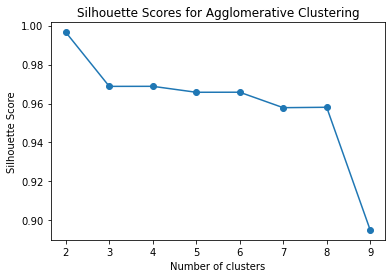

In [ ]:
# Finding best number of clusters
from sklearn.metrics import silhouette_score

silhouette_scores = []

for k in range(2, 10):
    model = AgglomerativeClustering(n_clusters=k)
    labels = model.fit_predict(to_use)
    score = silhouette_score(to_use, labels)
    silhouette_scores.append(score)

plt.plot(range(2,10), silhouette_scores, marker='o')
plt.title('Silhouette Scores for Agglomerative Clustering')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

# 10 hours 25 mins (625m)

In [22]:
# Detect outliers
df_labeled = detect_outliers_with_agglomerative(sales_df, to_use, distance_threshold=6000, min_cluster_size=20)
# 22 mins

In [23]:
df_labeled[df_labeled['is_anomaly']]
# 6209 @ distance=550
# 5318 @ distance=850, 10
# 5053 @ distance=1050, cluster_size = 20
# 3357 @ distance=2050
# 2051 @ distance=4050
# 1692 @ distance=5050
# 1639 @ distance=5500
# 1584 # distance=6000

,FiscalYear,AccDocNo,Dr_Cr,DateOfAccDocEntry,DateOfAccDocEntry_and_TimeOfEntry (MYT),NoOfLineItemInAccDoc,GL_DESCRIPTION,Amt_localCurrencyFormatted,Document Type Description,Quantity,...,Dr_Other Revenue - G\L Account,Dr_Revenue - G\L Account,IS Rep,OS Rep,Carrier Key Desc,Customer PO Number,Sold-To Id,Revenue,cluster,is_anomaly
48,2019,9911314077,"[Cr, Dr, Dr, Cr, Dr, Cr, Dr, Cr]",2019-01-03,2019-01-03 17:54:50,"[001, 002, 003, 004, 005, 006, 007, 008]","[Accounts Receivable Control Account, Third Pa...","[-42.06, 42.06, 129552.52, -129552.52, 0.05, -...",Billing Doc.Transfer,"[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",...,0.0,42.11,None,None,None,None,None,-42.06,831,True
173,2019,9911342447,"[Dr, Cr, Cr, Dr, Cr, Cr, Dr, Cr, Cr, Dr, Cr, C...",2018-12-30,2018-12-31 13:02:07,"[001, 002, 003, 004, 005, 006, 007, 008, 009, ...","[Accounts Receivable Control Account, Warranty...","[201122.0, -42828.0, -14606.6, 14606.6, -25800...",Billing Doc.Transfer,"[0.0, 6.0, 0.0, 0.0, 4.0, 0.0, 0.0, 4.0, 0.0, ...",...,0.0,0.00,None,None,None,None,None,201122.00,567,True
502,2019,9911351305,"[Dr, Cr, Cr, Dr, Cr, Cr, Dr, Cr, Cr, Dr, Cr, C...",2019-01-04,2019-01-04 17:01:21,"[001, 002, 003, 004, 005, 006, 007, 008, 009, ...","[Accounts Receivable Control Account, Warranty...","[100170.0, -2134.0, -1841.73, 1841.73, -2134.0...",Billing Doc.Transfer,"[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...",...,0.0,0.00,None,None,None,None,None,100170.00,939,True
505,2019,9911351358,"[Dr, Cr, Cr, Dr, Cr, Cr, Dr, Cr, Cr, Dr, Cr, C...",2019-01-04,2019-01-04 18:27:50,"[001, 002, 003, 004, 005, 006, 007, 008, 009, ...","[Accounts Receivable Control Account, Third Pa...","[213074.3, -128559.6, -78232.5, 78232.5, -3662...",Billing Doc.Transfer,"[0.0, 18.0, 0.0, 0.0, 18.0, 0.0, 0.0, 7.0, 0.0...",...,0.0,0.00,None,None,None,None,None,213074.30,1043,True
670,2019,9911352416,"[Dr, Cr, Cr, Dr, Cr, Dr, Cr, Cr, Dr, Cr, Dr, C...",2019-01-03,2019-01-03 16:30:45,"[001, 002, 003, 004, 005, 006, 007, 008, 009, ...","[Accounts Receivable Control Account, Third Pa...","[22707.6, -5586.6, -8177.08, 8177.08, -13614.4...",Billing Doc.Transfer,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",...,0.0,0.00,None,None,None,None,None,22707.60,785,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156286,2019,9950832213,"[Cr, Dr, Dr, Dr, Cr, Dr, Cr]",2019-09-17,2019-09-18 11:15:15,"[001, 002, 003, 004, 005, 006, 007]","[Accounts Receivable Control Account, Sales Re...","[-6890.0, 6500.0, 390.0, 4622.34, -4622.34, 10...",Bill Doc.Tr - Cr Mem,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",...,0.0,6500.00,[Kar Mun Carmen Chew],[MIN CHYI LEO],WILL CALL,[PO180301],RECARTS IMAGING SDN BHD,-6500.00,510,True
156288,2019,9950832214,"[Cr, Dr, Dr, Dr, Cr, Dr, Cr]",2019-09-17,2019-09-18 11:15:15,"[001, 002, 003, 004, 005, 006, 007]","[Accounts Receivable Control Account, Sales Re...","[-7955.24, 7504.94, 450.3, 3677.34, -3677.34, ...",Bill Doc.Tr - Cr Mem,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",...,0.0,7504.94,[Kar Mun Carmen Chew],[MIN CHYI LEO],WILL CALL,[20058],RECARTS IMAGING SDN BHD,-7504.94,510,True
156484,2019,9950834114,"[Cr, Dr]",2019-09-24,2019-09-25 10:15:08,"[001, 002]","[Accounts Receivable Control Account, Vendor P...","[-149036.69, 149036.69]",Bill Doc.Tr - Cr Mem,"[0.0, 1.0]",...,0.0,0.00,[Pooi Yee Ho],[Azril Ali Bin Ahmad Rashi],TLC-PJ,"[145428723, 145428297, 145428014, 14]",LIFETECH SOLUTIONS SDN BHD,0.00,113,True
156530,2019,9950835019,"[Cr, Dr]",2019-09-25,2019-09-25 18:15:16,"[001, 002]","[Accounts Receivable Control Account, Sales Re...","[-63639.0, 63639.0]",Bill Doc.Tr - Cr Mem,"[0.0, 3.0]",...,0.0,63639.00,[Enaliza Binti Anuar],[MIN CHYI LEO],WILL CALL,[00000688/01],GALAXY AUTOMATION SDN BHD,-63639.00,192,True


In [20]:
table_name = 'anomaly_res_agglomerative_full'
sql_db.fn_create_new_table_from_df(table_name=table_name, df=df_labeled, auto_data_type=True)
res=sql_db.fn_append_df_to_table(table_name=table_name, df=df_labeled)
print(res)

True


# Grading

In [24]:
anomaly_df = df_labeled[df_labeled['is_anomaly'] == 1].copy()
anomaly_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1538 entries, 48 to 156588
Data columns (total 80 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   FiscalYear                                  1538 non-null   int64         
 1   AccDocNo                                    1538 non-null   int64         
 2   Dr_Cr                                       1538 non-null   object        
 3   DateOfAccDocEntry                           1538 non-null   object        
 4   DateOfAccDocEntry_and_TimeOfEntry (MYT)     1538 non-null   datetime64[ns]
 5   NoOfLineItemInAccDoc                        1538 non-null   object        
 6   GL_DESCRIPTION                              1538 non-null   object        
 7   Amt_localCurrencyFormatted                  1538 non-null   object        
 8   Document Type Description                   1538 non-null   object        
 9   Quantity  

In [25]:
people = ['kam keong choy','pooi yee ho','seok yee chow']
# kam keong choy is also an OS rep

def add_probability_column(df):
    # Initialize probability column with 0s
    df = df.copy()  # Avoid modifying the original DataFrame
    df['probability'] = 0
    df['matched_conditions'] = [[] for _ in range(len(df))]  # List of strings for each row
    cols_present = ['matched_conditions']

    # Condition 1: 'Carrier Key Desc' == 'WILL CALL'
    if 'Carrier Key Desc' in df.columns:
        cond1 = df['Carrier Key Desc'].str.strip().str.upper() == 'WILL CALL'
        cond1 = cond1.fillna(False)
        df['probability'] += cond1.astype(int)
        # Add condition name to matched_conditions where True
        df.loc[cond1, 'matched_conditions'] = df.loc[cond1, 'matched_conditions'].apply(lambda x: x + ['Carrier Key Desc'])
        cols_present.append('Carrier Key Desc')

    # Condition 2: 'Customer PO Number' contains at least one string with 'WC'
    if 'Customer PO Number' in df.columns:
        def contains_wc(lst):
            if not isinstance(lst, list):
                return False
            return any(isinstance(s, str) and 'WC' in s.upper() for s in lst)

        cond2 = df['Customer PO Number'].apply(contains_wc)
        cond2 = cond2.fillna(False)
        df['probability'] += cond2.astype(int)
        df.loc[cond2, 'matched_conditions'] = df.loc[cond2, 'matched_conditions'].apply(lambda x: x + ['Customer PO Number'])
        cols_present.append('Customer PO Number')

    # Condition 3: 'IS Rep' == 'Chow Seok Yee'
    if 'IS Rep' in df.columns:
        def match_is_rep(val):
            val=val[0] if val else ""
            return val.strip().lower() in people
        
        cond3 = df['IS Rep'].apply(match_is_rep)
        cond3 = cond3.fillna(False)
        df['probability'] += cond3.astype(int)
        df.loc[cond3, 'matched_conditions'] = df.loc[cond3, 'matched_conditions'].apply(lambda x: x + ['IS Rep'])
        cols_present.append('IS Rep')

    # Condition 4: 'OS Rep' == 'Kam Keong Choy'
    if 'OS Rep' in df.columns:
        def match_os_rep(val):
            val=val[0] if val else ""
            return val.strip().lower() in people

        cond4 = df['OS Rep'].apply(match_os_rep)
        cond4 = cond4.fillna(False)
        df['probability'] += cond4.astype(int)
        df.loc[cond4, 'matched_conditions'] = df.loc[cond4, 'matched_conditions'].apply(lambda x: x + ['OS Rep'])
        cols_present.append('OS Rep')

    # Condition 5: RefKeyForLineItem like O / PMT
    if 'RefKeyForLineItem' in df.columns:
        def match_refkey(val):
            # val = list(set(val))
            # print(val)
            if isinstance(val, list):
                return any(
                    isinstance(item, str) and 'O/PMT' in item.replace(' ', '')
                    for item in val
                )
            return isinstance(val, str) and 'O/PMT' in val.replace(' ', '')

        cond_opmt = df['RefKeyForLineItem'].apply(match_refkey)
        cond_opmt = cond_opmt.fillna(False)
        df['probability'] += cond_opmt.astype(int)
        df.loc[cond_opmt, 'matched_conditions'] = df.loc[cond_opmt, 'matched_conditions'].apply(lambda x: x + ['RefKeyForLineItem'])
        cols_present.append('RefKeyForLineItem')

    return df, cols_present

In [26]:
final, cols_present = add_probability_column(anomaly_df)
final.groupby('probability')['AccDocNo'].count()

probability
0    1408
1     122
2       8
Name: AccDocNo, dtype: int64

In [27]:
overall, cols_present = add_probability_column(df_labeled)
overall.groupby('probability')['AccDocNo'].count()
# probability
# 0    147350
# 1      9193
# 2       197

probability
0    147350
1      9193
2       197
Name: AccDocNo, dtype: int64

# Old code<br>
Finding best number of clusters using Silhouette score

In [ ]:
from sklearn.metrics import silhouette_score

silhouette_scores = []

for k in range(2, 10):
    model = AgglomerativeClustering(n_clusters=k)
    labels = model.fit_predict(df_numeric)
    score = silhouette_score(df_numeric, labels)
    silhouette_scores.append(score)

plt.plot(range(2,10), silhouette_scores, marker='o')
plt.title('Silhouette Scores for Agglomerative Clustering')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from itertools import product

def find_best_agglo_params(df, n_clusters_range=None, linkage_options=None, 
                           affinity_options=None, scoring='silhouette', 
                           scale_data=True, verbose=True):
    """
    Finds the best hyperparameters for Agglomerative Clustering based on a scoring metric.

    Parameters:
        df (pd.DataFrame): Input dataframe with numerical features only.
        n_clusters_range (list): Range of cluster numbers to try.
        linkage_options (list): List of linkage options to consider.
        affinity_options (list): List of affinity (distance) metrics to consider.
        scoring (str): Metric to use for evaluation ('silhouette', 'calinski', 'davies_bouldin').
        scale_data (bool): Whether to standardize the data before clustering.
        verbose (bool): Print progress and results.
        
    'silhouette': Higher is better (ranges from -1 to 1).
    'calinski': Higher is better.
    'davies_bouldin': Lower is better.

    Returns:
        dict: Best parameters found.
        float: Best score achieved.
    """

    # Default parameter ranges
    if n_clusters_range is None:
        n_clusters_range = range(2, 6)
    if linkage_options is None:
        linkage_options = ['ward', 'complete', 'average', 'single']
    if affinity_options is None:
        affinity_options = ['euclidean', 'manhattan', 'cosine']

    # Preprocess data
    X = df.values
    if scale_data:
        X = StandardScaler().fit_transform(X)

    # Initialize best parameters
    best_score = -np.inf if scoring != 'davies_bouldin' else np.inf
    best_params = {}

    # Iterate through all combinations
    param_combinations = product(n_clusters_range, linkage_options, affinity_options)
    
    for n_clusters, linkage, affinity in param_combinations:
        
        # Skip invalid combinations
        if linkage == 'ward' and affinity != 'euclidean':   # 'ward' linkage requires 'euclidean' distance
            continue
        
        try:
            model = AgglomerativeClustering(
                n_clusters=n_clusters,
                linkage=linkage,
                affinity=affinity,
                compute_distances=True
            )
            labels = model.fit_predict(X)

            # Compute score
            if scoring == 'silhouette' and n_clusters > 1:
                score = silhouette_score(X, labels)
            elif scoring == 'calinski':
                score = calinski_harabasz_score(X, labels)
            elif scoring == 'davies_bouldin':
                score = davies_bouldin_score(X, labels)
            else:
                continue  # skip invalid cases

            # Update best parameters
            if (scoring != 'davies_bouldin' and score > best_score) or \
               (scoring == 'davies_bouldin' and score < best_score):
                best_score = score
                best_params = {
                    'n_clusters': n_clusters,
                    'linkage': linkage,
                    'affinity': affinity
                }

            if verbose:
                print(f"Params: {best_params}, Score: {score:.4f}")

        except Exception as e:
            if verbose:
                print(f"Failed with params n_clusters={n_clusters}, linkage={linkage}, "
                      f"affinity={affinity}: {e}")
            continue

    return best_params, best_score

In [ ]:
# Find best parameters
best_params, best_score = find_best_agglo_params(df_numeric, scoring='silhouette')
print("Best Parameters:", best_params)
print("Best Score:", best_score)

Using inertia on agglomerative clustering<br>
Since Agglomerative Clustering doesn't compute inertia directly, you have to compute it manually after fitting the model.

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt

def wcss_agglomerative(X, max_clusters):
    wcss = []
    cluster_range = range(2, max_clusters + 1)
    
    for k in cluster_range:
        model = AgglomerativeClustering(n_clusters=k)
        labels = model.fit_predict(X)

        # Compute WCSS (Within-Cluster Sum of Squares)
        centers = np.array([X[labels == i].mean(axis=0) for i in range(k)])
        distances = np.sum(pairwise_distances(X, centers)**2, axis=1)
        wcss.append(np.sum(distances))
        
    return cluster_range, wcss

# Example usage
cluster_range, wcss_values = wcss_agglomerative(df_numeric.values, max_clusters=10)

plt.plot(cluster_range, wcss_values, marker='o')
plt.title("Elbow Method for Agglomerative Clustering")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

Using Gower distance:<br> similarity measure that can handle different types of data within the same dataset and is particularly useful in cluster analysis

In [ ]:
# Step 1: Compute Gower Distance Matrix
distance_matrix = gower.gower_matrix(grouped_data)
distance_matrix

In [ ]:
# Step 2: Tune hyperparameters (n_clusters and linkage)
def tune_agglomerative_clustering(distance_matrix, max_clusters=8):
    best_score = -1
    best_params = {}
    linkage_methods = ['complete', 'average', 'single']
    
    for linkage_method in linkage_methods:
        for n_clusters in range(2, max_clusters + 1):
            clusterer = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage=linkage_method)
            labels = clusterer.fit_predict(distance_matrix)
            
            # Avoid Silhouette Score when only one cluster exists
            if len(set(labels)) > 1:
                score = silhouette_score(distance_matrix, labels, metric='precomputed')
            else:
                score = -1
            
            print(f"Linkage: {linkage_method}, Clusters: {n_clusters}, Silhouette Score: {score:.4f}")
            
            if score > best_score:
                best_score = score
                best_params = {'n_clusters': n_clusters, 'linkage': linkage_method}
    
    return best_params, best_score

best_params, best_score = tune_agglomerative_clustering(df_numeric, max_clusters=6)
print("\nBest Parameters:", best_params)
print("Best Silhouette Score:", best_score)

In [ ]:
# Step 3: Perform final clustering with best parameters
final_clusterer = AgglomerativeClustering(
    n_clusters=best_params['n_clusters'],
    affinity='precomputed',
    linkage=best_params['linkage']
)
labels = final_clusterer.fit_predict(distance_matrix)

# Step 4: Detect Outliers Based on Cluster Size or Distance
def detect_outliers(labels, distance_matrix, threshold=1.5):
    cluster_distances = []
    for label in set(labels):
        idxs = np.where(labels == label)[0]
        cluster_distances.append(np.mean(distance_matrix[np.ix_(idxs, idxs)]))
    
    mean_distance = np.mean(cluster_distances)
    std_distance = np.std(cluster_distances)
    
    outlier_indices = []
    for i, label in enumerate(labels):
        cluster_idx = np.where(labels == label)[0]
        avg_dist = np.mean(distance_matrix[i][cluster_idx])
        if avg_dist > mean_distance + threshold * std_distance:
            outlier_indices.append(i)
    
    return outlier_indices

outliers = detect_outliers(labels, distance_matrix, threshold=1.5)
print("\nDetected Outliers Indices:", outliers)

# Optional: Visualize dendrogram
linked = linkage(distance_matrix, best_params['linkage'])
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top')
plt.title('Dendrogram')
plt.xlabel('Data Index')
plt.ylabel('Distance')
plt.show()

# Final assignment of clusters
df['Cluster'] = labels
df['IsOutlier'] = df.index.isin(outliers)
print("\nFinal Cluster Assignment:\n", df)

In [ ]:
# Perform Agglomerative Clustering
agglo_cluster = AgglomerativeClustering(
    n_clusters=3,  # Change based on required number of clusters
    affinity='precomputed',  # Since Gower matrix is used
    linkage='average'  # Recommended for Gower distance
)
labels = agglo_cluster.fit_predict(gower_dist)

# Add cluster labels to DataFrame
grouped_data['Cluster'] = labels
grouped_data

In [ ]:
# Visualizing Dendrogram
plt.figure(figsize=(10, 5))
sch.dendrogram(sch.linkage(gower_dist, method='average'))
plt.title("Dendrogram for Agglomerative Clustering using Gower Distance")
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.show()

In [ ]:
# Sample dataset with mixed types
data = {
    'Age': [25, 35, 45, 50, 23, 34, 100],  # Numerical
    'Gender': ['M', 'F', 'F', 'M', 'M', 'F', 'M'],  # Categorical
    'Income': [50000, 60000, 70000, 80000, 45000, 62000, 90000],  # Numerical
    'Education': ['BSc', 'MSc', 'PhD', 'BSc', 'BSc', 'MSc', 'HS']  # Categorical
}

df = pd.DataFrame(data)

# Encode categorical variables if needed (optional; Gower handles strings)
for col in df.select_dtypes(include='object').columns:
    grouped_data[col] = LabelEncoder().fit_transform(df[col])